## Import MIGraphX Python Library

References:<br>
https://github.com/naomifridman/Unet_Brain_tumor_segmentation

In [1]:
import migraphx
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time

## Fetch U-NET ONNX Model

In [2]:
!wget -nc https://github.com/cagery/unet-onnx/raw/main/unet_13_256.onnx

File ‘unet_13_256.onnx’ already there; not retrieving.



## Load ONNX Model

In [3]:
model = migraphx.parse_onnx("224_224_160_dyanmic_bs.onnx")

In [4]:
model.compile(migraphx.get_target("gpu"))

## Print model parameters

In [5]:
print(model.get_parameter_names())
print(model.get_parameter_shapes())

['input']
{'input': float_type, {1, 4, 224, 224, 160}, {32112640, 8028160, 35840, 160, 1}}


In [6]:
img_type=['FLAIR', 'T1','T1CE', 'T2']

In [12]:
import os, sys, glob
import numpy as np
import SimpleITK as sitk
import sys
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
%matplotlib inline

In [13]:
import pandas as pd
import numpy as np
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
from scipy import ndimage
import random

In [14]:
red_multiplier = [1, 0.2, 0.2]
green_multiplier = [0.35,0.75,0.25]
blue_multiplier = [0,0.5,1.]#[0,0.25,0.9]
yellow_multiplier = [1,1,0.25]
brown_miltiplier = [40./255, 26./255, 13./255]
my_colors=[blue_multiplier, yellow_multiplier, brown_miltiplier]

In [15]:
from importlib import reload  # Python 3.4+ only.

In [16]:
import visualization_utils  as vu
reload(vu)

<module 'visualization_utils' from '/code/AMDMIGraphX/AMDMIGraphX/examples/python_unet/visualization_utils.py'>

In [17]:
def show_img_lable(img, lbl, modality = 0):
    
    if (len(lbl.shape)> 2):
        lbl[0,0,3]=1 # for uniqe colors in plot
        lbl = lbl_from_cat(lbl)
    vu.show_n_images([img[:,:,modality],lbl, show_lable_on_image4(img[:,:,modality],lbl)],
                    titles = [img_type[modality], 'Label', 'Label on '+ img_type[modality]]);


In [18]:
def read_img_sitk(img):
    inputImage = sitk.ReadImage( img )
    inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )
    image = sitk.GetArrayFromImage(inputImage)
    return image

In [27]:
# ima files are of the form
# BraTS19_TCIA04_192_1_flair.nii.gz  
# BraTS19_TCIA04_192_1_t1.nii.gz    
# BraTS19_TCIA04_192_1_t2.nii.gz
# BraTS19_TCIA04_192_1_seg.nii.gz    
# BraTS19_TCIA04_192_1_t1ce.nii.gz

def read_image_into_numpy(dirpath):
    
    img_id = os.path.basename(dirpath)
    np_image=np.zeros((4, 155, 240, 240), dtype=np.float32)
    
    ## Flair
    flair_img = os.path.join(dirpath, img_id+'_flair.nii')
    if (not os.path.isfile(flair_img)):
        print(flair_img,' not found aborting')
        return None
    np_image[0] = read_img_sitk(flair_img)
        
    ## T1
    t1_nb4_img = os.path.join(dirpath, img_id+'_t1_nb4.nii')
    if (not os.path.isfile(t1_nb4_img)):
        #print(t1_nb4_img,' not found')
        t1_img = os.path.join(dirpath, img_id+'_t1.nii')
        if (not os.path.isfile(t1_img)):
            print(t1_img,' not found aborting')
            return None
        np_image[1] = read_img_sitk(t1_img)
    else:
        np_image[1] = read_img_sitk(t1_nb4_img)    
            
    ## T1CE
    t1ce_nb4_img = os.path.join(dirpath, img_id+'_t1ce_nb4.nii')
    if (not os.path.isfile(t1ce_nb4_img)):
        #print(t1ce_nb4_img,' not found')
        t1ce_img = os.path.join(dirpath, img_id+'_t1ce.nii')
        if (not os.path.isfile(t1ce_img)):
            print(t1ce_img,' not found aborting')
            return None
        np_image[2] = read_img_sitk(t1ce_img)
    else:
        np_image[2] = read_img_sitk(t1ce_nb4_img)    
    
        
    ## T2
    t2_img = os.path.join(dirpath, img_id+'_t2.nii')
    if (not os.path.isfile(t2_img)):
        print(t2_img,' not found aborting')
        return None
    np_image[3] = read_img_sitk(t2_img)

    return np_image

In [28]:
def read_lable_into_numpy(dirpath):
    
    img_id = os.path.basename(dirpath)
    np_image=np.zeros((155, 240, 240), dtype=np.int)
    
    ## lable
    lable_img = os.path.join(dirpath, img_id+'_seg.nii')
    if (not os.path.isfile(lable_img)):
        print(lable_img,' not found aborting')
        return None
    np_image = read_img_sitk(lable_img).astype(int)

    return np_image

In [29]:
def bbox2_3D(img):

    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return [rmin, rmax, cmin, cmax, zmin, zmax]

In [39]:
np_img = read_image_into_numpy('/code/AMDMIGraphX/sampleData/HGG/BraTS19_2013_10_1')
np_img.shape

(4, 155, 240, 240)

<Figure size 432x360 with 0 Axes>

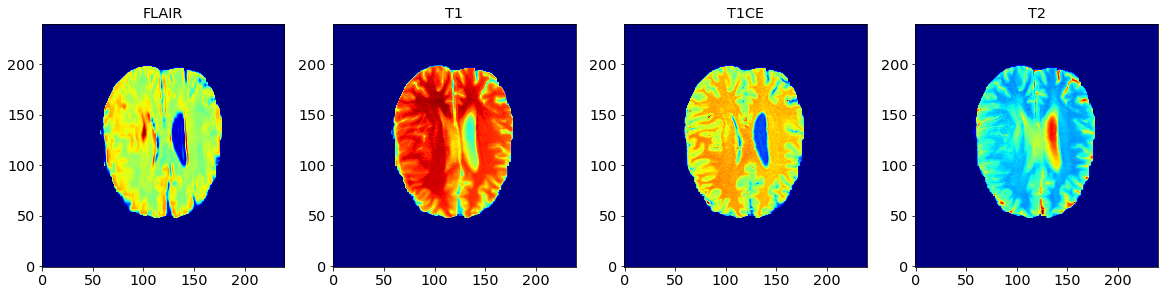

In [37]:
vu.show_n_images(np_img[:,100,:,:], titles=img_type)

<Figure size 432x360 with 0 Axes>

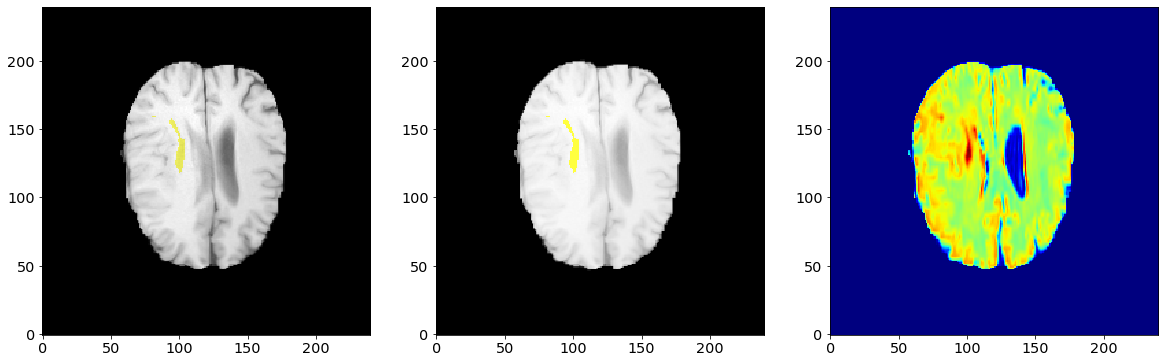

In [41]:
np_lbl = read_lable_into_numpy('/code/AMDMIGraphX/sampleData/HGG/BraTS19_2013_10_1')
np_lbl.shape
img1 = vu.show_lable_on_image4(np_img[1,100,:,:], np_lbl[100])
img2 = vu.show_lable_on_image(np_img[1,100,:,:], np_lbl[100])
vu.show_n_images([img1,img2,np_img[0,100]])

## Sample Input Image
a) native (T1) and b) post-contrast T1-weighted (T1Gd), c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes, and were acquired with different clinical protocols and various scanners from multiple (n=19) institutions, mentioned as data contributors here.